In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
data=pd.read_csv('data.csv')

In [150]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [151]:
X =data.drop('country',axis=1).values

In [152]:
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [153]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [154]:
def distance_matrix(X):
    n = len(X)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = euclidean_distance(X[i], X[j])
            D[i, j] = d
            D[j, i] = d
    return D

In [155]:
def hierarchical_average_linkage(X, k):
    n = len(X)

    clusters = [{i} for i in range(n)]
    sizes = [1] * n
    
    D = distance_matrix(X)

    while len(clusters) > k:
        
        masked_D = D.copy()
        np.fill_diagonal(masked_D, np.inf)

        i, j = np.unravel_index(np.argmin(masked_D), masked_D.shape)

        
        new_cluster = clusters[i] | clusters[j]
        new_size = sizes[i] + sizes[j]

        
        new_distances = []
        for m in range(len(clusters)):
            if m != i and m != j:
                d = (sizes[i] * D[i, m] + sizes[j] * D[j, m]) / new_size
                new_distances.append(d)

        
        for idx in sorted([i, j], reverse=True):
            clusters.pop(idx)
            sizes.pop(idx)
            D = np.delete(D, idx, axis=0)
            D = np.delete(D, idx, axis=1)

        
        clusters.append(new_cluster)
        sizes.append(new_size)

        # Updating distance matrix
        new_row = np.array(new_distances + [0.0])
        D = np.vstack([D, new_row[:-1]])
        D = np.column_stack([D, new_row])

    return clusters



In [156]:
def clusters_to_labels(clusters, n):
    labels = np.zeros(n, dtype=int)
    for idx, cluster in enumerate(clusters):
        for point in cluster:
            labels[point] = idx
    return labels


In [157]:
k = 3

clusters_avg = hierarchical_average_linkage(X_scaled, k)
labels_avg = clusters_to_labels(clusters_avg, len(X_scaled))

data['avg_cluster'] = labels_avg

In [158]:
def silhouette_score(X, labels):
    n = len(X)
    unique_clusters = np.unique(labels)
    silhouette_vals = []

    for i in range(n):
        same_cluster = X[labels == labels[i]]
        other_clusters = [X[labels == c] for c in unique_clusters if c != labels[i]]

        if len(same_cluster) > 1:
            a = np.mean([euclidean_distance(X[i], x) for x in same_cluster if not np.array_equal(x, X[i])])
        else:
            a = 0

        b = np.inf
        for cluster in other_clusters:
            mean_dist = np.mean([euclidean_distance(X[i], x) for x in cluster])
            b = min(b, mean_dist)


        s = (b - a) / max(a, b) if max(a, b) != 0 else 0
        silhouette_vals.append(s)

    return np.mean(silhouette_vals)

In [159]:
sil = silhouette_score(X_scaled, labels_avg)
print("Silhouette Score:", sil)


Silhouette Score: 0.568035311008152


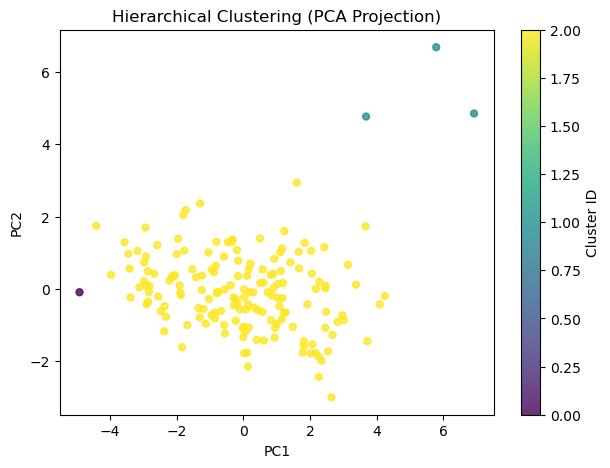

In [160]:
def visualize_pca(X_scaled, clusters):
    
    cov = np.cov(X_scaled, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    W = eigvecs[:, idx[:2]]
    X_pca = X_scaled @ W
    
    
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], 
                c=clusters, cmap='viridis', 
                s=25, alpha=0.8)
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    
    plt.title("Hierarchical Clustering (PCA Projection)")
    plt.colorbar(label="Cluster ID")
    plt.show()


visualize_pca(X_scaled, labels_avg)

In [161]:
avg_cluster_summary = (
    data
    .drop(columns=['kmeans_cluster'], errors='ignore') 
    .groupby('avg_cluster')
    .mean(numeric_only=True)
)

print(avg_cluster_summary)

             child_mort     exports    health     imports        income  \
avg_cluster                                                               
0            130.000000   25.300000  5.070000   17.400000   5150.000000   
1              4.133333  176.000000  6.793333  156.666667  64033.333333   
2             38.335583   38.723307  6.826810   45.050711  16355.294479   

              inflation  life_expec  total_fer          gdpp  
avg_cluster                                                   
0            104.000000   60.500000    5.84000   2330.000000  
1              2.468000   81.433333    1.38000  57566.666667  
2              7.289337   70.417178    2.95908  12208.490798  


In [162]:
for c in sorted(data['avg_cluster'].unique()):
    print(f"\nCluster {c}:")
    
    print(data[data['avg_cluster'] == c]['country'].values)


Cluster 0:
['Nigeria']

Cluster 1:
['Luxembourg' 'Malta' 'Singapore']

Cluster 2:
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada'
 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia'
 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel'
 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Ki

## TRYING WARD's linkage

### Ward's Linkage Update Formula

When merging clusters $i$ and $j$ into a new cluster, the distance to any other cluster $k$ is updated using:

$$
d_{(i \cup j), k} = \sqrt{\frac{(N_i + N_k) d_{i,k}^2 + (N_j + N_k) d_{j,k}^2 - N_k d_{i,j}^2}{N_i + N_j + N_k}}
$$

**Where:**
* $d_{x,y}$: The distance between cluster $x$ and cluster $y$.
* $N_x$: The number of points (size) in cluster $x$.

In [163]:
# changing update formula

In [164]:
def hierarchical_wards_linkage(X, k):
    n = len(X)

    clusters = [{i} for i in range(n)]
    sizes = [1] * n
    
    D = distance_matrix(X)

    while len(clusters) > k:
        
        masked_D = D.copy()
        np.fill_diagonal(masked_D, np.inf)

        i, j = np.unravel_index(np.argmin(masked_D), masked_D.shape)

        
        new_cluster = clusters[i] | clusters[j]
        new_size = sizes[i] + sizes[j]

        
        new_distances = []
        for m in range(len(clusters)):
            if m != i and m != j:
                size_i = sizes[i]
                size_j = sizes[j]
                size_m = sizes[m]
                size_total = size_i + size_j + size_m


                d = np.sqrt(
                    ( (size_i + size_m) * (D[i, m]**2) + 
                      (size_j + size_m) * (D[j, m]**2) - 
                      size_m * (D[i, j]**2) ) / size_total
                )
                new_distances.append(d)

        
        for idx in sorted([i, j], reverse=True):
            clusters.pop(idx)
            sizes.pop(idx)
            D = np.delete(D, idx, axis=0)
            D = np.delete(D, idx, axis=1)

        
        clusters.append(new_cluster)
        sizes.append(new_size)

        # Updating distance matrix
        new_row = np.array(new_distances + [0.0])
        D = np.vstack([D, new_row[:-1]])
        D = np.column_stack([D, new_row])

    return clusters


In [165]:
clusters_avg = hierarchical_wards_linkage(X_scaled, k)
labels_avg = clusters_to_labels(clusters_avg, len(X_scaled))

data['avg_cluster'] = labels_avg

In [166]:
sil = silhouette_score(X_scaled, labels_avg)
print("Silhouette Score:", sil)

Silhouette Score: 0.24563001303300652


In [167]:
avg_cluster_summary = (
    data
    .drop(columns=['kmeans_cluster'], errors='ignore') 
    .groupby('avg_cluster')
    .mean(numeric_only=True)
)

print(avg_cluster_summary)

             child_mort    exports    health    imports        income  \
avg_cluster                                                             
0            105.070370  23.589630  6.507037  39.662963   1589.740741   
1             31.617925  39.990368  6.353679  48.085527  11341.886792   
2              5.961765  58.508824  8.501176  48.902941  47588.235294   

             inflation  life_expec  total_fer          gdpp  
avg_cluster                                                  
0             7.142778   57.248148   5.433704    667.888889  
1             9.120604   70.921698   2.654623   6407.367925  
2             4.115500   79.982353   1.888529  43170.588235  


In [168]:
for c in sorted(data['avg_cluster'].unique()):
    print(f"\nCluster {c}:")
    
    print(data[data['avg_cluster'] == c]['country'].values)


Cluster 0:
['Afghanistan' 'Benin' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 "Cote d'Ivoire" 'Gambia' 'Guinea' 'Guinea-Bissau' 'Haiti' 'Kenya'
 'Madagascar' 'Malawi' 'Mali' 'Mozambique' 'Niger' 'Rwanda' 'Senegal'
 'Sierra Leone' 'Tanzania' 'Togo' 'Uganda' 'Zambia']

Cluster 1:
['Albania' 'Algeria' 'Angola' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Bahamas' 'Bangladesh' 'Barbados' 'Belarus' 'Belize'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil'
 'Bulgaria' 'Cambodia' 'Cape Verde' 'Chile' 'China' 'Colombia'
 'Congo, Rep.' 'Costa Rica' 'Croatia' 'Cyprus' 'Czech Republic'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Fiji' 'Gabon' 'Georgia' 'Ghana' 'Grenada'
 'Guatemala' 'Guyana' 'Hungary' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Jamaica' 'Jordan' 'Kazakhstan' 'Kiribati' 'Kyrgyz Republic' 'Lao'
 'Latvia' 'Lebanon' 'Lesotho' 'Liberia' 'Lithuania' 'Maced

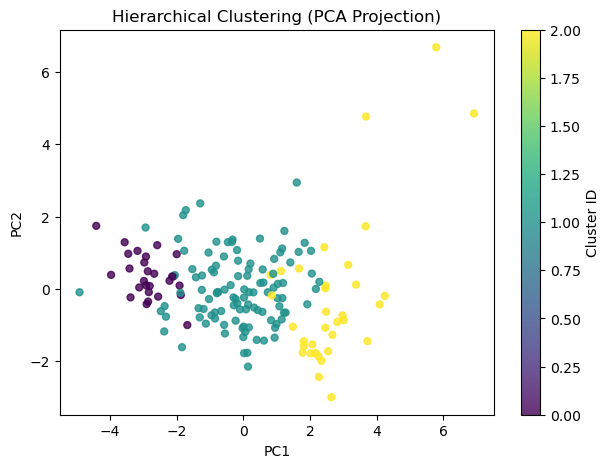

In [169]:
visualize_pca(X_scaled, labels_avg)